# Mục Đích
> Bài này được viết ra nhằm tổng hợp lại một vài kiến tức cơ bản của text classification như sentiment analysis (phân loại cảm xúc) hay phân loại câu hỏi... Bài này sẽ tổng hợp các kiến thức của các bài trước hoặc bổ sung kiến thức mới về NLP.
> Bài này được viết dựa trên nội dung của bài [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) do team Tensorflow thực hiện. Có rất nhiều bài khác nhau ở đây, chúng ta cũng có thể sử dụng nguồn này làm tài liệu luyện thi Tensorflow Developer Certificate được.

In [ ]:
#default_exp nlp.basic_text_classification

In [ ]:
#export
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os, re, shutil, string
import matplotlib.pyplot as plt
%matplotlib inline

# Sentiment Analysis
> Chúng ta sẽ sử dụng dữ liệu IMBD kinh điển cho phân loại cảm xúc.

## Download dữ liệu
> Sử dụng phương thức get_file của keras.utils để download dữ liệu từ url về:

In [ ]:
#hide
?keras.utils.get_file

Signature:
keras.utils.get_file(
    fname,
    origin,
    untar=False,
    md5_hash=None,
    file_hash=None,
    cache_subdir='datasets',
    hash_algorithm='auto',
    extract=False,
    archive_format='auto',
    cache_dir=None,
)
Docstring:
Downloads a file from a URL if it not already in the cache.

By default the file at the url `origin` is downloaded to the
cache_dir `~/.keras`, placed in the cache_subdir `datasets`,
and given the filename `fname`. The final location of a file
`example.txt` would therefore be `~/.keras/datasets/example.txt`.

Files in tar, tar.gz, tar.bz, and zip formats can also be extracted.
Passing a hash will verify the file after download. The command line
programs `shasum` and `sha256sum` can compute the hash.

Example:

```python
path_to_downloaded_file = tf.keras.utils.get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True)
```

Arguments:
    fname: Name of the file.

In [ ]:
#export
# Download dữ liệu từ url về path:
path = '/home/ddpham/git/TFExam/data/'
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = keras.utils.get_file('aclImdb_v1', origin=url, untar=True, cache_dir=path, cache_subdir='')

In [ ]:
#export
# Tạo lại path:
path = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
#hide
# Kiểm tra path:
print("Path: ", path)
print("Subfolders of Path:", os.listdir(path))

Path:  /home/ddpham/git/TFExam/data/aclImdb
Subfolders of Path: ['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']


In [ ]:
#hide
# Kiểm tra subfolders:
print("Test subfolders:", os.listdir(os.path.join(path, 'test')), 
      "\nTrain subfolders:", os.listdir(os.path.join(path, 'train')))

Test subfolders: ['labeledBow.feat', 'neg', 'urls_pos.txt', 'pos', 'urls_neg.txt'] 
Train subfolders: ['labeledBow.feat', 'neg', 'unsupBow.feat', 'urls_pos.txt', 'pos', 'urls_neg.txt', 'urls_unsup.txt', 'unsup']


Chúng ta có thể thấy trong tập train có dữ liệu `unsup` là dữ liệu unsupervised của IMDB. Do đây là dữ liệu chúng ta sẽ không sử dụng nên cần được loại bỏ path trước khi load dữ liệu tạo tập train.

In [ ]:
#hide
# Kiểm tra subfolder:
print("Sample files in subfolders: \n", os.listdir(os.path.join(path, 'train', 'neg'))[:10])

Sample files in subfolders: 
 ['713_1.txt', '10511_1.txt', '9228_3.txt', '9898_1.txt', '7524_1.txt', '7108_3.txt', '3376_3.txt', '485_3.txt', '8039_1.txt', '12103_3.txt']


In [ ]:
#hide
# Kiểm tra dữ liệu:
with open(f'{path}/train/neg/713_1.txt') as file:
    print(file.readline())

Can I please say first of all, that I felt so strongly about this movie that I signed up to IMDb specifically to review it. And my review? This is easily the worst movie I have ever seen.<br /><br />The synopsis of the movie sounded interesting- Nazis, occult, time travel, etc., but the movies plot failed to properly bring all these elements together. Remember the episode of South Park that featured manatees writing Family Guy using 'idea balls'? Did these manatees also write Unholy? Its like the writer wanted to include all these different ideas, but had no idea how to link them all together, and then to make things make even less sense, included a Donnie Darko-esquire time travel theme to the ending, messing up the chronology.<br /><br />I could tell from early on that this was a bad movie. Special effects were too low budget for anything better than straight to DVD. The acting wasn't great, but in fairness I've seen worse. I will praise the Nazi paintings, they were creepy, but the 

__Trước khi chúng ta bắt đầu, hãy loại bỏ subfolder unsup:__

In [ ]:
#export
# Loại unsup khỏi path:
remove_dir = os.path.join(path, 'train/unsup')
shutil.rmtree(remove_dir)

In [ ]:
#hide
# Kiểm tra lại directory:
os.listdir(os.path.join(path, 'train'))

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt']

## Tạo dữ liệu
> Với dữ liệu IMDB, chúng ta có thể dùng phương pháp `text_dataset_from_directory` tương tự như `image_dataset_from_directory` đã dùng với image.

In [ ]:
#hide
?keras.preprocessing.text_dataset_from_directory

Signature:
keras.preprocessing.text_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    max_length=None,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
)
Docstring:
Generates a `tf.data.Dataset` from text files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Then calling `text_dataset_from_directory(main_directory, labels='inferred')`
will return a `tf.data.Dataset` that yields batches of texts from
the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Only `.txt` files are supported at this time.

Arguments:
  directory: Directory where the data is located.
      If `labels` is "inferred", it should contain
      subdirectories, each containing tex

In [ ]:
#export
# Tạo tập train và valid từ folder train:
train_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f'{path}/train'
    , labels='inferred'
    , label_mode='binary'
#     , class_names=['neg', 'pos']
    , batch_size=32
    , validation_split=0.2
    , subset='training'
    , seed=42
)
valid_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f'{path}/train'
    , labels = 'inferred'
    , label_mode='binary'
    , batch_size=32
    , validation_split=0.2
    , subset='validation'
    , seed=42
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


__Lưu ý:__
Chúng ta luôn luôn nhớ cần kiểm tra lại dữ liệu sau tất cả các bước load dữ liệu, biến đổi dữ liệu và tạo features để đảm bảo dữ liệu đầu ra đúng với yêu cầu 

In [ ]:
#hide
# Kiểm tra lại dữ liệu từ tập train:
for batch in train_ds.take(1):
    print(batch[0][:3])
    print(batch[1][:3])

tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicat

## Text Vectorization
> Chúng ta sử dụng TextVectorization để tokenize text và convert text về dạng sequence.

In [ ]:
#hide
?keras.layers.experimental.preprocessing.TextVectorization

Init signature: keras.layers.experimental.preprocessing.TextVectorization(*args, **kwargs)
Docstring:     
Text vectorization layer.

This layer has basic options for managing text in a Keras model. It
transforms a batch of strings (one sample = one string) into either a list of
token indices (one sample = 1D tensor of integer token indices) or a dense
representation (one sample = 1D tensor of float values representing data about
the sample's tokens).

If desired, the user can call this layer's adapt() method on a dataset.
When this layer is adapted, it will analyze the dataset, determine the
frequency of individual string values, and create a 'vocabulary' from them.
This vocabulary can have unlimited size or be capped, depending on the
configuration options for this layer; if there are more unique values in the
input than the maximum vocabulary size, the most frequent terms will be used
to create the vocabulary.

The processing of each sample contains the following steps:

  1. standa

### Biến đổi dữ liệu cơ bản
> Trong layer text vectorization, có biến: `standardize` giúp chúng ta thực hiện các bước biến đổi/chuẩn hóa dữ liệu như: chuyển chữ về dạng lowercase (tùy chọn, có thể ko sử dụng nếu bạn thấy không cần thiết); loại bỏ các ký tự đặc biệt sử dụng trong ngôn ngữ html... Đây là các bước cần thiết để chúng ta có được dữ liệu sạch và chuẩn trước khi chúng ta bắt đầu việc tách từ, gộp từ, tokenize từ và tạo sequence (vector) hoặc tf-idf...

__Lưu ý:__

Tensorflow có module `strings` có rất nhiều phương pháp xử lý dữ liệu dạng chữ khác nhau rất hữu dụng để chúng ta có thể sử dụng biến đổi dữ liệu.

In [ ]:
#hide
dir(tf.strings)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'as_string',
 'bytes_split',
 'format',
 'join',
 'length',
 'lower',
 'ngrams',
 'reduce_join',
 'regex_full_match',
 'regex_replace',
 'split',
 'strip',
 'substr',
 'to_hash_bucket',
 'to_hash_bucket_fast',
 'to_hash_bucket_strong',
 'to_number',
 'unicode_decode',
 'unicode_decode_with_offsets',
 'unicode_encode',
 'unicode_script',
 'unicode_split',
 'unicode_split_with_offsets',
 'unicode_transcode',
 'unsorted_segment_join',
 'upper']

In [ ]:
#export
def text_cleansing(input_text):
    # Convert sang lower case:
    lower_text = tf.strings.lower(input_text)
    # Loại bỏ các ký tự html:
    html_text = tf.strings.regex_replace(lower_text, "<br />", " ")
    # Loại bỏ các dấu:
    puct_text = tf.strings.regex_replace(html_text, "[%s]" % re.escape(string.punctuation), "")
    return puct_text

In [ ]:
#hide
# Danh sách puntuations:
'[%s]' % re.escape(string.punctuation)

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]'

In [ ]:
#hide
# Test thử dữ liệu:
for batch in train_ds.take(1):
    print(batch[0][1], '\n')
    print(text_cleansing(batch[0][1]))
    break

tf.Tensor(b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does the perspective of the viewer.<br /><br />So is 'Homicide' which from the title tries to set the mind of the viewer to the usual crime drama. The principal characters are two cops, one Jewish and one Irish who deal with a racially charged area. The murder of an old Jewish shop owner who proves to be an ancient veteran of the Israeli Independence war triggers the Jewish identity in the mind and heart of the Jewish detective.<br /><br />This is were the flaws of the film are the more obvious. The process of awakening is theatrical and hard to believe, the group of Jewish militants is operatic, and the way the detective eventually walks to the final violent confrontation is pathetic. The end of the film itself is Mamet-like sm

In [ ]:
#export
# Tạo layer vectorization:
max_features = 10000
sequence_length = 250

vectorization_layer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features
    , standardize=text_cleansing
    , split='whitespace'
    , ngrams=None
    , output_mode='int'
    , output_sequence_length=sequence_length
)

**Lưu ý:**

Tưowng tự như `Tokenizer` trong `keras.preprocesisng.text`, TextVectorization có phương pháp `adapt` để giúp chúng ta xây dựng vocabulary cho tập dữ liệu dựa vào tập train. Do đó trước khi bắt đầu tiếp các bước tiếp theo, chúng ta sẽ `adapt` TextVectorization với tập dữ liệu train.

In [ ]:
#export
# Gộp toàn bộ dữ liệu text vào:
for _, text in train_ds.enumerate():
    if _ == 0:
        raw_text_train = text[0]
    else: raw_text_train = tf.concat([raw_text_train, text[0]], axis=-1)

In [ ]:
#hide
# Kiểm tra dữ liệu:
print("#: ", raw_text_train.shape[0])
print("Sample data:\n", raw_text_train[:5])

#:  20000
Sample data:
 tf.Tensor(
[b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops ta

In [ ]:
#export
# Adapt vectorization_layer với dữ liệu text từ tập train:
vectorization_layer.adapt(raw_text_train)

In [ ]:
#hide
# Kiểm tra lại với 1 sample:
## Lưu ý: dữ liệu đầu vào của vectorization_layer phải là dạng list, nên ở đây
## với 1 sample của raw_text_train, chúng ta phải biến nó thành dạng list:
vectorization_layer([raw_text_train[0]])

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1287,  313, 2380,  313,  661,    7,    2,   52,  229,    5,    2,
         200,    3,   38,  170,  669,   29, 5492,    6,    2,   83,  297,
         549,   32,  410,    3,    2,  186,   12,   29,    4,    1,  191,
         510,  549,    6,    2, 8229,  212,   46,  576,  175,  168,   20,
           1, 5361,  290,    4,    1,  761,  969,    1,    3,   24,  935,
        2271,  393,    7,    1, 1675,    4, 3747,  250,  148,    4,  112,
         436,  761, 3529,  548,    4, 3633,   31,    2, 1331,   28, 2096,
           3, 2912,    9,    6,  163,    4, 1006,   20,    2,    1,   15,
          85,   53,  147,    9,  292,   89,  959, 2314,  984,   27,  762,
           6,  959,    9,  564,   18,    7, 2140,   32,   24, 1254,   36,
           1,   85,    3, 3298,   85,    6, 1410,    3, 1936,    2, 3408,
         301,  965,    7,    4,  112,  740, 1977,   12,    1, 2014, 2772,
           3,    4,  428,    3, 5177,    6,  512, 1254,    1,  2

**Lưu ý:**
Bằng cách sử dụng toàn bộ dữ liệu text của tập train để xây dựng vocab cho layer vectorization, chúng ta đã có được phần này đầy đủ. Hãy áp dụng cho các tập dữ liệu khác:

In [ ]:
#hide
# Kiểm tra shape của dữ liệu đầu vào:
train_ds

<BatchDataset shapes: ((None,), (None, 1)), types: (tf.string, tf.float32)>

Đôi khi, chúng ta có thể quên mất loại dữ liệu của tập train/valid (dạng tuple hoặc dictionary). Trước khi áp dụng phương pháp nào vào dữ liệu này, bạn cần biết rõ dạng dữ liệu để đảm bảo khi tạo phương pháp, chúng ta ko bị nhầm lẫn giữa 2 loại dữ liệu trên.

In [ ]:
#export
# Tạo hàm biến đổi dữ liệu để map vào các tập dataset;
def vectorize_text(text, label):
    
    # Biến đổi từng comment thành dạng list:
    text = tf.expand_dims(text, -1) 
    return vectorization_layer(text), label   

In [ ]:
#hide
# Thử test với 1 batch của tập train:
for batch in train_ds.take(1):
    print("Original comment:\n", batch[0][1], '\n')
    print("Vectorized comment:'\n", vectorize_text(batch[0][1], batch[1][1]))

Original comment:
 tf.Tensor(b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!", shape=(), dtype=string) 

Vectorized comment:'
 (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  237, 2350, 2350,    3,    1,   12,    2,    1,    5,   22,
         922, 5790,   36, 5633,  153,   69,   25,   21,  340,   11,   19,
           4,  693,    5, 1718,   70, 1131, 1131,  177,    4, 1885,   45,
         

**Lưu ý:**

Chúng ta có thể thấy, với độ dài của sequence = 250, không phải comment nào cũng đủ dài như vậy, nên sẽ có những comment khi biến đổi sang sequence thì có rất nhiều giá trị 0 đằng sau được `pad` vào để đảm bảo độ dài của sequence = 250.

In [ ]:
#export
# Áp dụng với tập train và valid:
train_ds = train_ds.map(vectorize_text)
valid_ds = valid_ds.map(vectorize_text)

### Cấu hình dữ liệu
> Với dữ liệu dạng Dataset, chúng ta có 2 phương pháp cấu hình dữ liệu có thể áp dụng để tránh bị vấn để về I/O: `cache` và `prefetch`.
Về cơ bản `cache` là việc máy sẽ ưu tiên một phần của bộ nhớ tạm thời (RAM) (hoặc ổ cứng tại máy local - vs hệ thống dữ liệu ditributed) cho dữ liệu còn `prefetch` là việc máy (CPU) sẽ tính toán trước dữ liệu cho batch tiếp theo khi model đang train batch hiện tại trên GPU. Bạn có thể thấy là với Tensorflow, chúng ta phải tương đối am hiểu về những kiến thức cơ bản của CS để có thể hiểu được ý nghĩa của việc tuning performance như thế này.

In [ ]:
#hide
?tf.data.AUTOTUNE

Type:        int
String form: -1
Docstring:  
int([x]) -> integer
int(x, base=10) -> integer

Convert a number or string to an integer, or return 0 if no arguments
are given.  If x is a number, return x.__int__().  For floating point
numbers, this truncates towards zero.

If x is not a number or if base is given, then x must be a string,
bytes, or bytearray instance representing an integer literal in the
given base.  The literal can be preceded by '+' or '-' and be surrounded
by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
Base 0 means to interpret the base from the string as an integer literal.
>>> int('0b100', base=0)
4


In [ ]:
#export
AUTOTUNE = tf.data.AUTOTUNE # để tf tự quyết định số lượng prefetch dựa vào cấu hình của máy tính 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#hide
# Kiểm tra lại shape của dữ liệu:
train_ds

<PrefetchDataset shapes: ((None, 250), (None, 1)), types: (tf.int64, tf.float32)>

## Tạo model cơ bản
> Chúng ta sẽ tạo 1 model có cấu trúc tương đối đơn giản: 

### Xây dựng kiến trúc cơ bản

In [ ]:
#export
# Tạo kiến trúc cơ bản:
embedding_dim = 64
model = keras.Sequential()
    
# Tạo embedding layer:
model.add(keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length))

# Dropout
model.add(keras.layers.Dropout(.2))

# Sử dụng globalaveragepool1D để giảm chiều và lấy
# giá trị average của từng row của matrix embeding
model.add(keras.layers.GlobalAveragePooling1D())

# Tiếp tục dropout:
model.add(keras.layers.Dropout(.2))

# Tạo dense layer để tiếp tục giảm size:
model.add(keras.layers.Dense(10, activation='relu'))

# Tạo layer dự báo:
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile model:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
dropout (Dropout)            (None, 250, 64)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 640,661
Trainable params: 640,661
Non-trainable params: 0
__________________________________________________

### Đào tạo

In [ ]:
#export
# Train model:
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/10
625/625 [==============================] - 20s 29ms/step - loss: 0.6461 - accuracy: 0.6603 - val_loss: 0.4115 - val_accuracy: 0.8412
Epoch 2/10
625/625 [==============================] - 16s 26ms/step - loss: 0.3639 - accuracy: 0.8555 - val_loss: 0.3165 - val_accuracy: 0.8656
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2820 - accuracy: 0.8864 - val_loss: 0.2983 - val_accuracy: 0.8762
Epoch 4/10
625/625 [==============================] - 17s 26ms/step - loss: 0.2479 - accuracy: 0.9012 - val_loss: 0.2940 - val_accuracy: 0.8780
Epoch 5/10
625/625 [==============================] - 17s 26ms/step - loss: 0.2271 - accuracy: 0.9114 - val_loss: 0.2918 - val_accuracy: 0.8790
Epoch 6/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2133 - accuracy: 0.9195 - val_loss: 0.2952 - val_accuracy: 0.8780
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2026 - accuracy: 0.9227 - val_loss: 0.2954 - val_accuracy:

Chúng ta có thể thấy, kể từ epoch thứ 3 trở đi, model bắt đầu có dấu hiệu overfit. Chúng ta có thể plot lại kết quả để dễ  hình dung hơn.

### Visualize kết quả
> Keras có lưu lại kết quả trong quá trình train model ở model.history, bao gồm cả dữ liệu về loss và metrics. Chúng ta hãy plot lại dữ liệu này theo epoch để dễ quan sát hơn.

In [ ]:
#hide
# Kiểm tra dữ liệu hisotry:
model.history.history

{'loss': [0.5900413990020752,
  0.35086187720298767,
  0.2806062698364258,
  0.25015172362327576,
  0.2301107943058014,
  0.2160499095916748,
  0.20527395606040955,
  0.1980276256799698,
  0.19125179946422577,
  0.18440547585487366],
 'accuracy': [0.7352499961853027,
  0.8586500287055969,
  0.8848000168800354,
  0.902400016784668,
  0.9103000164031982,
  0.9168499708175659,
  0.9230999946594238,
  0.9257000088691711,
  0.9285500049591064,
  0.9313499927520752],
 'val_loss': [0.4314160645008087,
  0.31800544261932373,
  0.2969827353954315,
  0.2911377251148224,
  0.28976067900657654,
  0.2912695109844208,
  0.2928432822227478,
  0.29422780871391296,
  0.2965157628059387,
  0.29804882407188416],
 'val_accuracy': [0.8339999914169312,
  0.8669999837875366,
  0.876800000667572,
  0.879800021648407,
  0.8820000290870667,
  0.8813999891281128,
  0.8822000026702881,
  0.8831999897956848,
  0.8835999965667725,
  0.8826000094413757]}

In [ ]:
#export
def plot_history(history: dict, metrics:str='accuracy'):
    # Tạo list cần plot:
    loss = [i for i in history if 'loss' in i]
    metrics = [i for i in history if f'{metrics}' in i]
    plots = [loss, metrics]
    
    # Plot:
    fig = plt.figure(figsize=(10, 4))
    for i in range(len(plots)):
        ax = plt.subplot(1, 2, i+1)
        for plot_item in plots[i]:
            ax.plot(history[plot_item])
            ax.legend(plots[i])
            ax.set_xlabel('epochs')
    plt.suptitle("Train's and Validation's Loss vs Metrics")
    plt.tight_layout()

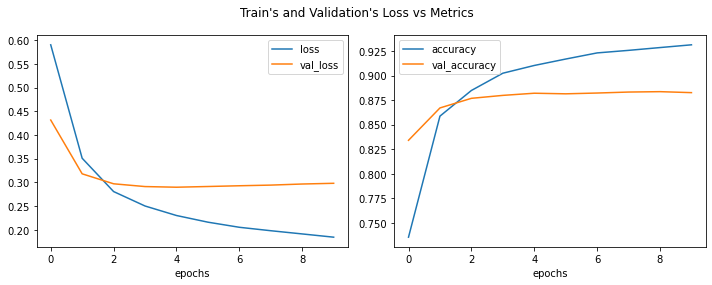

In [ ]:
#export
plot_history(model.history.history)

Chúng ta tạm thời chấp nhận kết quả này ở đây và chuyển sang 

### Đánh giá kết quả
> Sau khi đã hài lòng với kết quả được đào tạo. Chúng ta có thể đánh giá lại tính chính xác của model vs tập test. Ở bước trên, chúng ta đã không hề đề cập đến tập dữ liệu test, bây giờ là lúc để load dữ liệu và kiểm định lại model.

In [ ]:
#export
test_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f'{path}/test'
    , labels = 'inferred'
)

test_ds = test_ds.map(vectorize_text)

Found 25000 files belonging to 2 classes.


In [ ]:
#hide
# Kiểm tra lại dữ liệu:
for text in test_ds.take(1):
    print("New comment:\n", text[0][1].numpy())
    print("\nLabel:\n", text[1][1].numpy())

New comment:
 [  84    5    2 1101    5   24  106 5976    3 4508    5   63  402  571
    1  482   82   21  664 6576   81   19  240  307 7517    8   24  229
   19  153   24  323 3120    4  397 3872    5    1   63   27 1944   86
 1450   35   24  489   14  787    3  567   14  516    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

In [ ]:
#export
print("Đánh giá kết quả trên tập test:")
loss, accuracy = model.evaluate(test_ds)
print("Giá trị loss:", loss)
print("Giá trị accuary:", accuracy)

Đánh giá kết quả trên tập test:
782/782 [==============================] - 12s 16ms/step - loss: 0.3268 - accuracy: 0.8685
Giá trị loss: 0.3268018662929535
Giá trị accuary: 0.8685200214385986


**Lưu ý:**
Chúng ta có thể thấy giá trị của metric accuracy ở đây đang thấp hơn 1 chút so với tập valid và train ở bước trên, nhưng tương đối gần với tập valid (1% thấp hơn).

### Dự đoán
> Sau tất cả các bước trên, chúng ta có thể sử dụng model để dự đoán dữ liệu.  Chúng ta cần để ý là với dữ liệu raw (một câu comment), chúng ta cần phải biến đổi dữ liệu thành dạng đã được mã hóa (tokenzise) và thành 1 chuỗi mã hóa có độ dài 250 ký tự (sequence) giống như các bước ở trên. Để làm việc này được tốt nhất, chúng ta sẽ gộp các bước này và bước dự đoán vào làm 1.

In [ ]:
#export
## Kết hợp các layers thành kiến trúc mới
exp_model = keras.Sequential([
    
    # Layer đầu tiên là biến đổi dữ liệu:
    vectorization_layer,
    
    # Layer tiếp theo là layer dự đoán kết quả:
    model
])

exp_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics='accuracy')

**Kiểm định lại model:**
Để chắc chắn hơn, chúng ta hay kiểm định lại model trên tập test. Lần này, chúng ta chỉ cần load tập test từ folder mà thôi, bỏ qua bước biến đổi dữ liệu:

In [ ]:
#export
test_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f'{path}/test'
    , labels = 'inferred'
)


# Kiểm định lại model:
exp_model.evaluate(test_ds)

Found 25000 files belonging to 2 classes.
782/782 [==============================] - 14s 17ms/step - loss: 0.3310 - accuracy: 0.8668


[0.326802134513855, 0.8685200214385986]

In [ ]:
#export
# Tổng hợp lại model:
exp_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 250)               0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 640661    
Total params: 640,661
Trainable params: 640,661
Non-trainable params: 0
_________________________________________________________________


Okay, sau tất cả, giờ là lúc chúng ta dự đoán:

In [ ]:
#export
# Thử tài dự đoán:
inference_data = ["This movie is great, it shows compassion and love of human for the nature."
                  , "The content is a mess, I can figure out what's going on even at the end of the movie."
                  , "The movie has both pros and cons. While we see some good acting from the main actor, however, the story line is not up to grasp."]

exp_model.predict(inference_data)

array([[0.8573272 ],
       [0.10417002],
       [0.38536677]], dtype=float32)

# Multi-category Classification
> Ở phần trên, chúng ta đã phân loại cảm xúc với dữ liệu IMDB. Giờ chúng ta sẽ thử với phân loại câu hỏi của StackOverflow theo nhóm ngôn ngữ.

## Download dữ liệu

In [ ]:
#export
path = "/home/ddpham/git/TFExam/data/"
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
keras.utils.get_file(fname='stack_overflow_16k', origin=url, untar=True, cache_dir=path, cache_subdir='stack_overflow_16k')

'/home/ddpham/git/TFExam/data/stack_overflow_16k/stack_overflow_16k'

In [ ]:
#export
path = os.path.join(os.path.dirname(path), 'stack_overflow_16k')

In [ ]:
#hide
# Kiểm tra folder:
os.listdir(path)

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [ ]:
#hide
# Kiểm tra subfolder:
os.listdir(os.path.join(path, 'train'))

['java', 'javascript', 'python', 'csharp']

In [ ]:
#hide
# Kiểm tra subfolder
os.listdir(os.path.join(path, 'train', 'python'))[:10]

['1636.txt',
 '467.txt',
 '174.txt',
 '1301.txt',
 '1619.txt',
 '893.txt',
 '828.txt',
 '1467.txt',
 '1032.txt',
 '146.txt']

In [ ]:
#hide
# Kiểm tra dữ liệu:
with open(f'{path}/train/python/1636.txt') as file:
    print(file.readline())

"convert a string to datetime object in blank i have a date string defined as followed:..datestr = '2011-05-01'...i want to convert this into a datetime object so i used the following code..dateobj = datetime.datetime.strptime(datestr,'%y-%m-%d').print dateobj...but what gets printed is: 2011-05-01 00:00:00. i just need 2011-05-01. what needs to be changed in my code ?..thank you"



## Tạo dữ liệu
> Tương tự như trong bài sentiment analysis, chúng ta sẽ có các bước tạo dữ liệu tương đồng.

In [ ]:
#export
bs = 32
seed=345
train_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f'{path}/train'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=bs
    , seed=seed
    , validation_split=0.2
    , subset='training'
)
valid_ds = keras.preprocessing.text_dataset_from_directory(
    directory=f"{path}/train"
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=bs
    , seed=seed
    , validation_split=0.2
    , subset='validation'
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
#hide
# Kiểm tra dữ liệu:
for text in train_ds.take(1):
    print("Question: \n", text[0][1])
    print("Language: \n", text[1][1])

Question: 
 tf.Tensor(b'"only one word of a sentence prints using replace method as my class project i have written some codes that receives a sentence and if it has a special character by checking it\'s ascii code it replaces it with another one. but unfortunately every time it replaces and shows only first word and deletes rest of the sentence. please help me and if there\'s a better way for this it\'s appreciated...here\'s my code:..import blank.util.scanner;..public class helloworld {..public static void main(string[] arg) {.    scanner scanner = new scanner(system.in);.    string s = scanner.next();.    if (s.contains(""u0626"")) {.        string result = s.replaceall(""u0626"", ""u0628"");.        system.out.println(result);.    }...}...}"\n', shape=(), dtype=string)
Language: 
 tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)


In [ ]:
#hide
# Kiểm tra dữ liệu
train_ds.class_names

['csharp', 'java', 'javascript', 'python']

__Lưu ý:__
Ở đây chúng ta có thể thấy dữ liệu labels đang trả về kết quả dưới dạng array 0 và 1. Trong đó index của giá trị = 1 chính là loại ngôn ngữ được hỏi của câu hỏi. Cụ thể ở đây là `javascript`. Phần lớn các dữ liệu label được trả về dưới dạng `int` (một giá trị trong chuỗi giá  trị category của labels). Việc này sẽ ảnh hưởng đến loss mà chúng ta sẽ sử dụng trong model (`int -> spatial_categorical_crossentropy`; `categorical -> categorical_crossentropy`). Nếu chúng ta muốn đổi lại label theo cách int, trong phần tạo dữ liệu dataset, chọn label_mode='int'.

### Text Vectorization

In [ ]:
#export
max_tokens = 10000
sequence_length = 250

vectorization_layer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_tokens
    , standardize='lower_and_strip_punctuation'
    , split='whitespace'
    , output_mode='int'
    , output_sequence_length=sequence_length
)

In [ ]:
#export
# Tạo raw text để adapt vectorization layer:
raw_text = []
for _, text in train_ds.enumerate():
    for ind in range(32):
        raw_text.append([text[0][ind].numpy()])

In [ ]:
#hide
# Kiểm tra dữ liệu
raw_text[0]

[b'"queue implementation does not return first element i want to emulate a queue by using linked lists in blank. my general schema is to have a list of nodes, with two nodes that points to the first and last element of my queue. when i perform the dequeue() i want to get ride of the first element. so far what i have done is the following:..public class node {.    public object e;.    node next;..    public node(object e) {.        this.e = e;.    }.}..public class queue {.    node queuelist;.    node first, last;.    int count;..    public void enqueue(object n) {.        node temp = new node(n);.        temp.next = last;.        last = temp;.        if (queuelist == null) {.            first = temp;.        }.        count++;.        queuelist=temp;.    }..    public object dequeue() {.        node previous = last;.        node current = last.next;.        object num = null;.        if (count == 0).            system.out.println(""empty queue"");.        else {.            while (curr

In [ ]:
#export
vectorization_layer.adapt(raw_text)

In [ ]:
#hide
# Kiểm tra dữ liệu:
for text in valid_ds.take(1):
    print(vectorization_layer([text[0][10]]))

tf.Tensor(
[[  16   24   39    3  147    5  463   22   94  284    9    2  194   51
    81    4   42  371    5   18   14  285    2  240    4    5    1   44
     4   39   11   22   96    5  284    9    2  463    1  324    3   17
     5  463  246 6783    7    1    3   44    4   33  237    4   42   14
   240   76 1186    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [ ]:
#export:
def vectorize_text(x, y):
    x = tf.expand_dims(x, -1)
    return vectorization_layer(x), y

In [ ]:
#export
train_ds = train_ds.map(vectorize_text)
valid_ds = valid_ds.map(vectorize_text)

In [ ]:
#export
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#hide
train_ds

<PrefetchDataset shapes: ((None, 250), (None, 4)), types: (tf.int64, tf.float32)>

## Tạo model

In [ ]:
#export
keras.backend.clear_session()
embedding_dim = 64
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length)
    , keras.layers.GlobalMaxPooling1D()
    , keras.layers.Dropout(.5)
    , keras.layers.Dense(20, activation='relu')
    , keras.layers.Dropout(.2)
    , keras.layers.Dense(4, activation='softmax')
])
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop(learning_rate=1e-8)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 641,384
Trainable params: 641,384
Non-trainable params: 0
__________________________________________________

### Tìm lr phù hợp
> Chúng ta có thể kết hợp với bài học về tìm learning rate phù hợp cho bài toán của chúng ta với LearningRateScheduler trong callbacks

In [ ]:
#export
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 10e-8 * 10**(epoch/10) )

In [ ]:
#export
epochs=150
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/150
200/200 [==============================] - 5s 24ms/step - loss: 1.3890 - accuracy: 0.2539 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 2/150
200/200 [==============================] - 5s 23ms/step - loss: 1.3875 - accuracy: 0.2538 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 3/150
200/200 [==============================] - 5s 23ms/step - loss: 1.3882 - accuracy: 0.2428 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 4/150
200/200 [==============================] - 5s 23ms/step - loss: 1.3890 - accuracy: 0.2428 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 5/150
200/200 [==============================] - 5s 24ms/step - loss: 1.3899 - accuracy: 0.2413 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 6/150
200/200 [==============================] - 5s 23ms/step - loss: 1.3892 - accuracy: 0.2447 - val_loss: 1.3863 - val_accuracy: 0.2556
Epoch 7/150
200/200 [==============================] - 5s 24ms/step - loss: 1.3884 - accuracy: 0.2495 - val_loss: 1.3863 - val_accuracy:

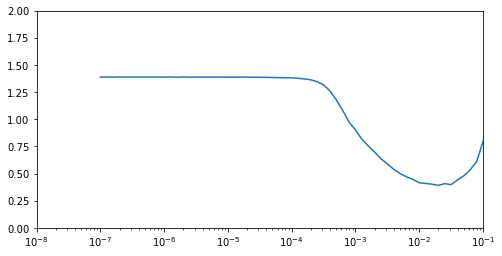

In [ ]:
#export
# Vẽ đồ thị learning rate và loss:
history = model.history
plt.figure(figsize=(8,4))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 2])
plt.show()

In [ ]:
#export
learning_rate = 5e-3
keras.backend.clear_session()
embedding_dim = 64
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length)
    , keras.layers.GlobalMaxPooling1D()
    , keras.layers.Dropout(.5)
    , keras.layers.Dense(20, activation='relu')
    , keras.layers.Dropout(.2)
    , keras.layers.Dense(4, activation='softmax')
])
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 641,384
Trainable params: 641,384
Non-trainable params: 0
__________________________________________________

In [ ]:
#export
epochs=50
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/50
200/200 [==============================] - 5s 24ms/step - loss: 1.2872 - accuracy: 0.3701 - val_loss: 0.8098 - val_accuracy: 0.6538
Epoch 2/50
200/200 [==============================] - 5s 24ms/step - loss: 0.9219 - accuracy: 0.6140 - val_loss: 0.6482 - val_accuracy: 0.7337
Epoch 3/50
200/200 [==============================] - 6s 28ms/step - loss: 0.7677 - accuracy: 0.6880 - val_loss: 0.5827 - val_accuracy: 0.7550
Epoch 4/50
200/200 [==============================] - 5s 26ms/step - loss: 0.6719 - accuracy: 0.7359 - val_loss: 0.5480 - val_accuracy: 0.7850
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 0.6126 - accuracy: 0.7654 - val_loss: 0.5173 - val_accuracy: 0.7819
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 0.5742 - accuracy: 0.7894 - val_loss: 0.5016 - val_accuracy: 0.7844
Epoch 7/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4977 - accuracy: 0.8167 - val_loss: 0.4937 - val_accuracy: 0.7944

Model của chúng ta ở thời điểm này là khá overfit. Một trong nhưng cách chúng ta có thể làm là thêm dropout layer, upgrade model với model tốt hơn.

## Nâng cấp model vs RNN

### Thêm 1 RNN

In [ ]:
#export
# Xóa thông tin các model cũ:
keras.backend.clear_session()

# Tạo input:
inputs = keras.Input(shape=(250))

# Tạo embeding:
embedding_dim = 64
embeding = keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length)(inputs)

# Tạo Bidirectional LSTM:
lstm = keras.layers.Bidirectional(keras.layers.LSTM(32))(embeding)

# Tạo dropout:
dropout = keras.layers.Dropout(0.2)(lstm)

# Tạo dense:
dense = keras.layers.Dense(20, activation='relu')(dropout)

# Tạo prediction:
prediction = keras.layers.Dense(4, activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=prediction)

# Tạo loss:
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Tạo lr scheduler:
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 10e-8 * 10 ** (epoch/10))

# Tạo optimizer:
optimizer = keras.optimizers.Adam(learning_rate=10e-8)

# Compile model:
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 666,216
Trainable params: 666,216
Non-trainable params: 0
_______________________________________________________

#### Tìm lr phù hợp

In [ ]:
#export
epochs=150
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=[lr_scheduler])

Epoch 1/150
200/200 [==============================] - 77s 344ms/step - loss: 1.3863 - accuracy: 0.2459 - val_loss: 1.3868 - val_accuracy: 0.2469
Epoch 2/150
200/200 [==============================] - 67s 334ms/step - loss: 1.3862 - accuracy: 0.2457 - val_loss: 1.3868 - val_accuracy: 0.2475
Epoch 3/150
200/200 [==============================] - 70s 350ms/step - loss: 1.3863 - accuracy: 0.2547 - val_loss: 1.3868 - val_accuracy: 0.2481
Epoch 4/150
200/200 [==============================] - 65s 326ms/step - loss: 1.3862 - accuracy: 0.2533 - val_loss: 1.3868 - val_accuracy: 0.2469
Epoch 5/150
200/200 [==============================] - 66s 329ms/step - loss: 1.3863 - accuracy: 0.2595 - val_loss: 1.3868 - val_accuracy: 0.2500
Epoch 6/150
200/200 [==============================] - 65s 324ms/step - loss: 1.3862 - accuracy: 0.2603 - val_loss: 1.3868 - val_accuracy: 0.2506
Epoch 7/150
200/200 [==============================] - 52s 260ms/step - loss: 1.3863 - accuracy: 0.2535 - val_loss: 1.3868 -

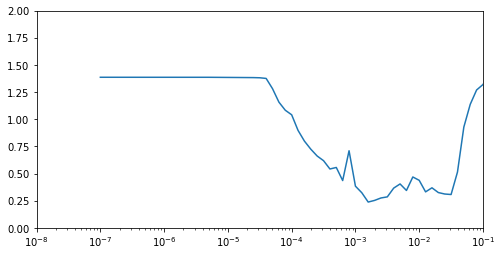

In [ ]:
#export
# Vẽ đồ thị learning rate và loss:
history = model.history
plt.figure(figsize=(8,4))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 2])
plt.show()

#### Train và valid model

In [ ]:
#export
# Xóa thông tin các model cũ:
keras.backend.clear_session()

# Tạo input:
inputs = keras.Input(shape=(250))

# Tạo embeding:
embedding_dim = 64
embeding = keras.layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, input_length=sequence_length)(inputs)

# Tạo Bidirectional LSTM:
lstm = keras.layers.Bidirectional(keras.layers.LSTM(32))(embeding)

# Tạo dropout:
dropout = keras.layers.Dropout(0.2)(lstm)

# Tạo dense:
dense = keras.layers.Dense(20, activation='relu')(dropout)

# Tạo prediction:
prediction = keras.layers.Dense(4, activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=prediction)

# Tạo loss:
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Tạo optimizer:
learning_rate=5e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile model:
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 84        
Total params: 666,216
Trainable params: 666,216
Non-trainable params: 0
_______________________________________________________

In [ ]:
#export
epochs=50
model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/50
200/200 [==============================] - 77s 344ms/step - loss: 1.3595 - accuracy: 0.2993 - val_loss: 1.1762 - val_accuracy: 0.4225
Epoch 2/50
200/200 [==============================] - 65s 326ms/step - loss: 1.1484 - accuracy: 0.4799 - val_loss: 0.9325 - val_accuracy: 0.5788
Epoch 3/50
200/200 [==============================] - 69s 345ms/step - loss: 0.8062 - accuracy: 0.6370 - val_loss: 0.7960 - val_accuracy: 0.6325
Epoch 4/50
200/200 [==============================] - 69s 345ms/step - loss: 0.6100 - accuracy: 0.7130 - val_loss: 0.7775 - val_accuracy: 0.6369
Epoch 5/50
200/200 [==============================] - 68s 339ms/step - loss: 0.5270 - accuracy: 0.7518 - val_loss: 0.7661 - val_accuracy: 0.6531
Epoch 6/50
200/200 [==============================] - 66s 329ms/step - loss: 0.4556 - accuracy: 0.7700 - val_loss: 0.8027 - val_accuracy: 0.6662
Epoch 7/50
200/200 [==============================] - 60s 300ms/step - loss: 0.4198 - accuracy: 0.7951 - val_loss: 0.8515 - val_ac

**Lưu ý:**
Kết quả này tương đối là tồi, mức độ overfit còn cao hơn so với việc chỉ sử dụng embedding layer, đây là điều dễ xảy ra vs LSTM.